## Required libraries

In [33]:
# ใช้ตัดคำภาษาไทย
import deepcut

# ใช้งาน regex
import re

# จัดการเกี่ยวกับ array
import numpy as np

import random
from sklearn.model_selection import train_test_split

# สำหรับทำ classify และทดสอบโมเดล
import nltk
from nltk import FreqDist, precision, recall, f_measure, NaiveBayesClassifier
from nltk.classify import apply_features
from nltk.classify import util

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import collections, itertools
import logging
import pandas as pd
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from pythainlp.tokenize import word_tokenize
from pythainlp.tag import pos_tag
from nltk.tokenize import RegexpTokenizer
import pickle
import time

%matplotlib inline

In [2]:
# Read the training data
data_pos = [line.strip() for line in open("sentiment-assignment/pos.txt", 'r', encoding="utf8")]
data_neg = [line.strip() for line in open("sentiment-assignment/neg.txt", 'r', encoding="utf8")]
data_neu = [line.strip() for line in open("sentiment-assignment/neu.txt", 'r', encoding="utf8")]

## Create necessary function

In [3]:
import re
import string

# Create function for cleaning the data
def clean_msg(msg):
    
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    msg = re.sub(r'<.*?>','', msg)
    
    # ลบ hashtag
    msg = re.sub(r'#','',msg)
    
    # remove 1-2 character that don't have any meaning
#     msg = re.sub('[A-Za-z0-9]','',msg)
    msg = re.sub('[0-9][0-9]','',msg)
    
    # ลบ เครื่องหมายคำพูด (punctuation)
    for c in string.punctuation:
        msg = re.sub(r'\{}'.format(c),'',msg)
    
    # ลบ separator เช่น \n \t
    msg = ' '.join(msg.split())
    
    # remove emoji and symbols
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
                           "]+", flags=re.UNICODE)
    msg = re.sub(emoji_pattern ,'',msg)
    
    return msg

# Remove empty sentence from list
def remove_emptyword_from_list(the_list, val, label):
    return [(word, label) for word in the_list if word != val]

In [8]:
# Create function for preprocessing data
def split_words (sentence):
    return word_tokenize(''.join(sentence.lower().split()),engine="newmm")

def get_words_in_sentences(sentences):
    all_words = []
    for (words) in sentences:
        all_words.extend(words)
    return all_words

def get_word_features(list_of_words):
    list_of_words = nltk.FreqDist(list_of_words)
    list_of_words.plot(10)
    word_features = [word[0] for word in list_of_words.most_common()]
    return word_features

## Preprocess and clean data

In [4]:
clean_neg = [clean_msg(str(txt)) for txt in data_neg]
clean_pos = [clean_msg(str(txt)) for txt in data_pos]
clean_neu = [clean_msg(str(txt)) for txt in data_neu]

In [5]:
final_pos = remove_emptyword_from_list(clean_pos,'',0)
final_neg = remove_emptyword_from_list(clean_neg,'',1)
final_neu = remove_emptyword_from_list(clean_neu,'',2)

In [6]:
# Merge all lists of data together to be a training set
data = final_pos+final_neg+final_neu

In [7]:
data

[('3', 0),
 ('เช', 0),
 ('ดิ', 0),
 ('ปะ', 0),
 ('พน', 0),
 ('Goๆ', 0),
 ('ครบ', 0),
 ('ค้ะ', 0),
 ('จอง', 0),
 ('จัด', 0),
 ('ชอบ', 0),
 ('ถึง', 0),
 ('ป้ะ', 0),
 ('ป๊ะ', 0),
 ('ปะๆ', 0),
 ('ไป', 0),
 ('ไปๆ', 0),
 ('มาก', 0),
 ('เย่', 0),
 ('เยป', 0),
 ('อูย', 0),
 ('Go', 0),
 ('Want', 0),
 ('กินๆ', 0),
 ('เครๆ', 0),
 ('งั่ม', 0),
 ('ง้ำๆ', 0),
 ('จ้ะ', 0),
 ('จะรอ', 0),
 ('จัดๆ', 0),
 ('จ๊าบ', 0),
 ('แดกก', 0),
 ('ได้ๆ', 0),
 ('เทอๆ', 0),
 ('ปร้ะ', 0),
 ('ป่ะ\u200b', 0),
 ('ป่ะๆ', 0),
 ('ป้ะๆ', 0),
 ('ป๊ะๆ', 0),
 ('ปะๆๆ', 0),
 ('ปะ', 0),
 ('ปะคะ', 0),
 ('ป่ะะ', 0),
 ('ปายย', 0),
 ('ไปๆ', 0),
 ('ไปๆๆ', 0),
 ('ไปคะ', 0),
 ('ไปปป', 0),
 ('ไปปะ', 0),
 ('ไปรึ', 0),
 ('พนนะ', 0),
 ('พนมะ', 0),
 ('ยะลา', 0),
 ('เยๆๆ', 0),
 ('รอๆๆ', 0),
 ('รอไป', 0),
 ('รอยุ', 0),
 ('ว้าว', 0),
 ('สุ้ๆ', 0),
 ('หิวๆ', 0),
 ('อบาก', 0),
 ('อิอิ', 0),
 ('อุ่น', 0),
 ('เอาๆ', 0),
 ('แอ๊ะ', 0),
 ('กินๆๆ', 0),
 ('กิน', 0),
 ('ครูขา', 0),
 ('ควรคะ', 0),
 ('ควรไป', 0),
 ('จะกิน', 0),
 ('จัดๆๆ', 0),
 ('จัดดด', 0),
 

In [9]:
pre_data = [(split_words(sentence), sentiment) for (sentence, sentiment) in data]

In [10]:
random.shuffle(pre_data)

In [11]:
# Create dataframe with 2 columns (text and label)
df = pandas.DataFrame(pre_data)
my_columns = ["text", "label"]
df.columns = my_columns

In [12]:
df

,text,label
0,"[สงสัย, ต้อง, ลาก, โซ่ตรวน, ไป, งาน, แล้ว, แหล...",2
1,"[ไม่, กิน, 5]",1
2,"[รอยเท้า, บน, ผืน, ทราย, พิง, ค์, แพน, เต, อร,...",2
3,"[แม่, ง, ราคา, เท่า, ฮอนด้า, แจ๊ส, เลย]",1
4,"[สิ่ง, ที่, ช่วย, เติมเต็ม, รสชาติ, ความ, อร่อ...",0
5,"[ผ้าอนามัย, เย็น, จิ๋ม, มัน, ไม่, ควร, มี, กลิ...",1
6,"[ปลายนิ้ว, ชา, อาจ, ตามมา, ได้, หลาย, โรค, นะค...",2
7,"[วันนี้, ว่าง, น้ะ]",2
8,"[ขาว, ๆๆ, แดง, ๆๆ, หวาน, ๆๆ, หอม, เนื้อ, ปู]",0
9,"[มาสด้า, กระหึ่ม, มอเตอร์, โชว์, อวด, โฉม, โมเ...",2


### Split the data to train and test set

Split all data to train and test set with ratio [85:15] = [train:test]

In [13]:
train, test = train_test_split(df, test_size=0.15, random_state = 48)

In [14]:
train

,text,label
15683,"[เค้า, ไม่ได้, เข้า, เอ็ม, เค, เลย]",2
19026,"[จาก, เรื่อง, บาบี, ก้อน, ลาม, ไป, อ่าน, พัน, ...",1
8306,"[อีก, นาน, แค่, ไหนจะ, ถูกกฎหมาย, ครับ]",0
6938,"[อยาก, ลอง, กิน, ชา, ไข่มุก, แมคโดนัลด์, ให้, ...",1
7453,"[อยาก, ฟัง, ข่าวดี, คราบ, บ, สู้, ๆ, นะ, ครับ,...",0
15676,"[เบื่อ, ไก่, อยาก, กิน, เอ็ม, เค]",1
19038,"[มัน, ไม่ดี, ตรง, ที่, กู, ไม่, ถูก, กะ, เบียร...",1
11641,[ขาดไม่ได้],2
21428,"[4, วิธี, เตรียมพร้อม, ขับรถ, ใน, ช่วง, เทศกาล...",2
26842,"[ถ้า, อ่าน, โพส, เรา, ก่อน, จะ, เข้าใจ, จุดประ...",2


### Split train set to train and validate set for training the model

Split all data to train and test set with ratio [80:20] = [train:validate] and random state 48

In [15]:
train_set, val_set = train_test_split(train, test_size=0.2, random_state = 48)

Break down text into such tokens (word, characters, or n-grams). Transforming text into numeric tensors. 

After 'fit' text to the tokenizer, generate index that represent each word. And transform sentence into a vector that use those indexes of word to represent word in sentences in order.

Make each vector has the same size by adding more zero or cut off the rest.

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_feature = 10000 
max_len = 500

tokenizer = Tokenizer(num_words = max_feature)
tokenizer.fit_on_texts(train_set['text'])
sequences = tokenizer.texts_to_sequences(train_set['text'])
train_data_seq = pad_sequences(sequences, maxlen=max_len)

In [17]:
len(train_data_seq)

18629

In [18]:
train_data_seq

array([[   0,    0,    0, ...,    2,   51, 1380],
       [   0,    0,    0, ...,   55,   46,   77],
       [   0,    0,    0, ...,  906, 4881,  351],
       ...,
       [   0,    0,    0, ...,    1,    2, 5504],
       [   0,    0,    0, ...,   22,   74, 1158],
       [   0,    0,    0, ...,    1,   71,   33]])

In [19]:
val_sequences = tokenizer.texts_to_sequences(val_set['text'])
val_data_seq = pad_sequences(val_sequences, maxlen=max_len)

In [20]:
val_data_seq

array([[   0,    0,    0, ...,  394,   28,   17],
       [   0,    0,    0, ...,    0,  206,  523],
       [   0,    0,    0, ...,   11,   10,   26],
       ...,
       [   0,    0,    0, ..., 4025,  516,  714],
       [   0,    0,    0, ...,  597,   92, 1432],
       [   0,    0,    0, ..., 1701, 5613,  229]])

In [21]:
len(val_data_seq)

4658

In [22]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(train_set['label'])
encoded_train = encoder.transform(train_set['label'])
# convert integers to variables (i.e. one hot encoded)
train_one_hot_label = np_utils.to_categorical(encoded_train)

In [23]:
train_one_hot_label

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [24]:
len(train_one_hot_label)

18629

In [25]:
encoder.fit(val_set['label'])
encoded_test = encoder.transform(val_set['label'])
val_one_hot_label = np_utils.to_categorical(encoded_test)

In [26]:
val_one_hot_label

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [27]:
len(val_one_hot_label)

4658

In [28]:
# Create function to plot the training result
def plot_history(history):
    
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    
    # Select the first axis
    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylim([0, 1])
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylim([0, 3])
    plt.legend()

    plt.show()

## Modeling and compilation

In [29]:
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.models import model_from_json
from keras.models import load_model

embedded_dim=100

model = Sequential()
model.add(Embedding(500, embedded_dim, input_length = max_len, trainable=False))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          50000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 417,619
Trainable params: 367,619
Non-trainable params: 50,000
_________________________________________________________________


In [134]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Create callback to reduce learning rate when the performance do not improve
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)
callbacks = [earlystop, learning_rate_reduction]

In [31]:
import time
# Start timing
start = time.time()

e=10
# Training
print('Training .....')
h1 = model.fit(train_data_seq, train_one_hot_label, validation_data=(val_data_seq, val_one_hot_label), epochs=e, batch_size=64, verbose=2, callbacks=callbacks)
    
stop = time.time()
etime = stop - start

print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, e, etime/e))

Training .....
Train on 18629 samples, validate on 4658 samples
Epoch 1/10
 - 406s - loss: 0.9312 - acc: 0.5845 - val_loss: 0.8711 - val_acc: 0.6189
Epoch 2/10
 - 420s - loss: 0.8909 - acc: 0.6070 - val_loss: 0.8794 - val_acc: 0.6267
Epoch 3/10
 - 372s - loss: 0.8824 - acc: 0.6117 - val_loss: 0.8453 - val_acc: 0.6340
Epoch 4/10
 - 352s - loss: 0.8673 - acc: 0.6213 - val_loss: 0.8343 - val_acc: 0.6413
Epoch 5/10
 - 352s - loss: 0.8609 - acc: 0.6213 - val_loss: 0.8258 - val_acc: 0.6383

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
 - 352s - loss: 0.8487 - acc: 0.6291 - val_loss: 0.8235 - val_acc: 0.6408

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 7/10
 - 353s - loss: 0.8467 - acc: 0.6264 - val_loss: 0.8177 - val_acc: 0.6458
Epoch 8/10
 - 353s - loss: 0.8415 - acc: 0.6337 - val_loss: 0.8149 - val_acc: 0.6443

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 9/10
 -

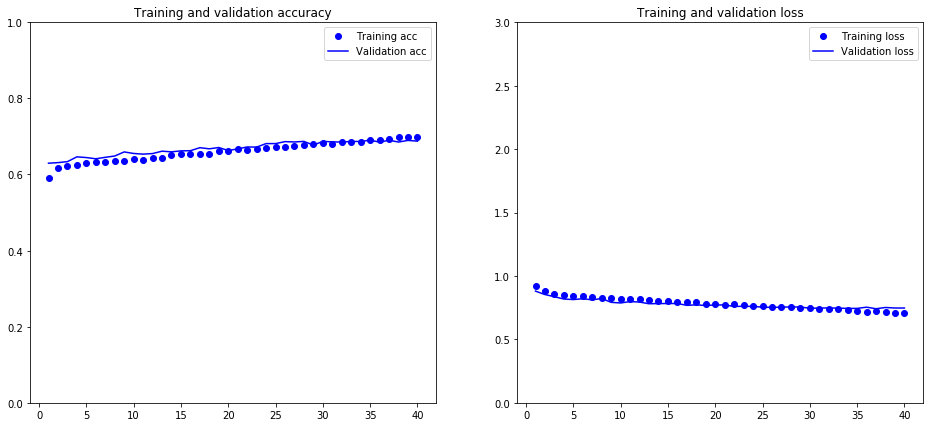

In [31]:
model_name = "model1.hdf5"
model.save(model_name)
plot_history(h1)

In [84]:
from keras.layers import Dense, Activation, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, Bidirectional, Flatten, MaxPooling1D
from keras import backend as K
K.clear_session()

model2 = Sequential()
model2.add(Embedding(500, embedded_dim, input_length = max_len))
model2.add(Conv1D(32, 7, activation='relu'))
model2.add(MaxPooling1D(5))
model2.add(Conv1D(32, 7, activation='relu'))
model2.add(LSTM(8, dropout = 0.3, recurrent_dropout = 0.5))
model2.add(Dense(3, activation = 'softmax'))
model2.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          50000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 80,971
Trainable params: 80,971
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Start timing
start = time.time()

e=15
# Training
print('Training .....')
h2 = model2.fit(train_data_seq, train_one_hot_label, validation_data=(val_data_seq, val_one_hot_label), epochs=e, batch_size=64, verbose=1)
    
stop = time.time()
etime = stop - start

print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, e, etime/e))

Training .....
Train on 18629 samples, validate on 4658 samples
Epoch 1/15
18629/18629 [==============================] - 50s 3ms/step - loss: 0.9886 - acc: 0.5631 - val_loss: 0.9939 - val_acc: 0.5764
Epoch 2/15
18629/18629 [==============================] - 48s 3ms/step - loss: 0.9945 - acc: 0.5649 - val_loss: 0.9598 - val_acc: 0.5846
Epoch 3/15
18629/18629 [==============================] - 49s 3ms/step - loss: 0.9596 - acc: 0.5755 - val_loss: 0.9077 - val_acc: 0.6146
Epoch 4/15
18629/18629 [==============================] - 50s 3ms/step - loss: 0.9257 - acc: 0.5969 - val_loss: 0.8998 - val_acc: 0.6176
Epoch 5/15
18629/18629 [==============================] - 51s 3ms/step - loss: 0.9135 - acc: 0.6071 - val_loss: 0.9634 - val_acc: 0.5957
Epoch 6/15
18629/18629 [==============================] - 49s 3ms/step - loss: 0.9517 - acc: 0.5797 - val_loss: 0.9280 - val_acc: 0.5906
Epoch 7/15
18629/18629 [==============================] - 50s 3ms/step - loss: 0.9299 - acc: 0.5864 - val_loss: 0.

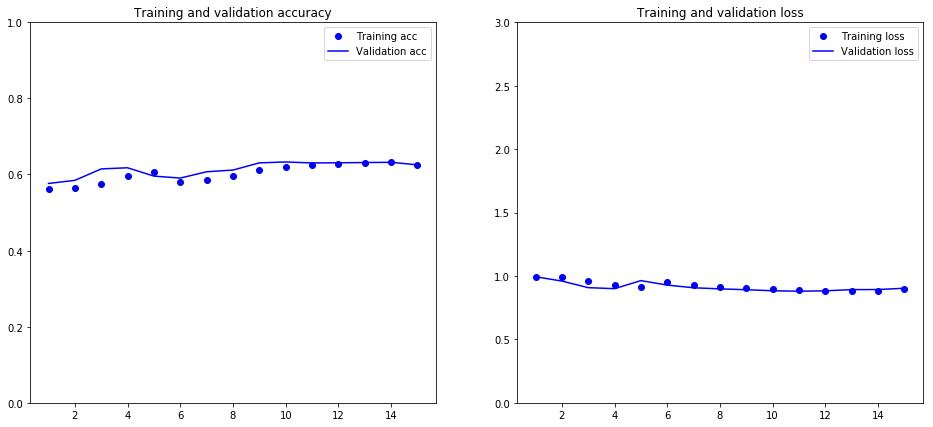

In [35]:
model_name = "model2.hdf5"
model2.save(model_name)
plot_history(h2)

In [36]:

K.clear_session()

m3 = Sequential()
m3.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m3.add(Conv1D(32, 7, activation='relu'))
m3.add(MaxPooling1D(5))
m3.add(Conv1D(32, 7, activation='relu'))
m3.add(GRU(8, dropout = 0.5, recurrent_dropout = 0.3))
m3.add(Dropout(0.5))
m3.add(Dense(3, activation = 'softmax'))
m3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 984       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total para

In [37]:
# Start timing
start = time.time()

e=20
# Training
print('Training .....')
h3 = m3.fit(train_data_seq, train_one_hot_label, validation_data=(val_data_seq, val_one_hot_label), epochs=e, batch_size=32, verbose=1)
    
stop = time.time()
etime = stop - start

print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, e, etime/e))

Training .....
Train on 18629 samples, validate on 4658 samples
Epoch 1/20
18629/18629 [==============================] - 82s 4ms/step - loss: 0.9262 - acc: 0.6033 - val_loss: 0.8255 - val_acc: 0.6520
Epoch 2/20
18629/18629 [==============================] - 79s 4ms/step - loss: 0.8258 - acc: 0.6562 - val_loss: 0.7886 - val_acc: 0.6675
Epoch 3/20
18629/18629 [==============================] - 80s 4ms/step - loss: 0.7739 - acc: 0.6800 - val_loss: 0.8128 - val_acc: 0.6728
Epoch 4/20
18629/18629 [==============================] - 81s 4ms/step - loss: 0.7149 - acc: 0.7061 - val_loss: 0.8133 - val_acc: 0.6660
Epoch 5/20
18629/18629 [==============================] - 80s 4ms/step - loss: 0.6552 - acc: 0.7301 - val_loss: 0.8539 - val_acc: 0.6754
Epoch 6/20
18629/18629 [==============================] - 80s 4ms/step - loss: 0.6010 - acc: 0.7554 - val_loss: 0.9106 - val_acc: 0.6756
Epoch 7/20
18629/18629 [==============================] - 79s 4ms/step - loss: 0.5519 - acc: 0.7788 - val_loss: 0.

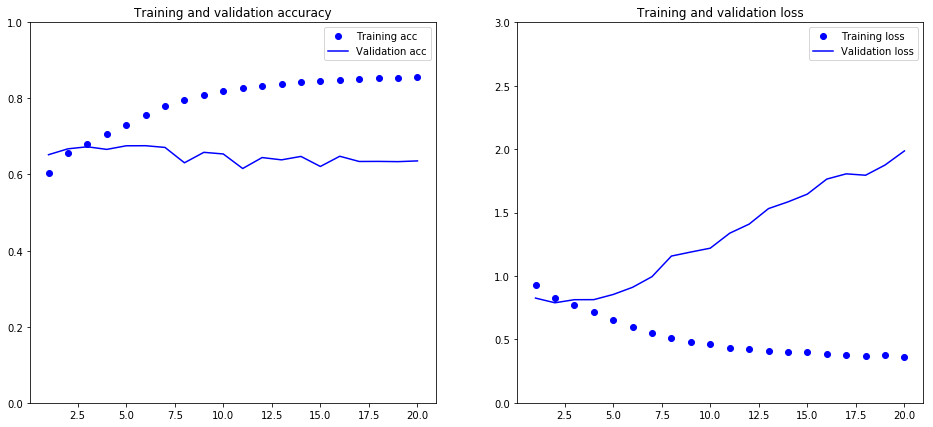

In [38]:
model_name = "model3.hdf5"
m3.save(model_name)
plot_history(h3)

In [39]:
m4 = Sequential()
m4.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m4.add(GRU(16, dropout = 0.2, recurrent_dropout = 0.2))
m4.add(Dropout(0.3))
m4.add(Dense(3, activation = 'softmax'))
m4.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                5616      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 1,005,667
Trainable params: 1,005,667
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Start timing
start = time.time()

e=20
# Training
print('Training .....')
h4 = m4.fit(train_data_seq, train_one_hot_label, validation_data=(val_data_seq, val_one_hot_label), epochs=e, batch_size=64, verbose=1)
    
stop = time.time()
etime = stop - start

print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, e, etime/e))

Training .....
Train on 18629 samples, validate on 4658 samples
Epoch 1/20
18629/18629 [==============================] - 191s 10ms/step - loss: 0.8679 - acc: 0.6202 - val_loss: 0.7476 - val_acc: 0.6889
Epoch 2/20
18629/18629 [==============================] - 190s 10ms/step - loss: 0.7245 - acc: 0.6989 - val_loss: 0.6960 - val_acc: 0.7080
Epoch 3/20
18629/18629 [==============================] - 191s 10ms/step - loss: 0.6684 - acc: 0.7260 - val_loss: 0.6889 - val_acc: 0.7151
Epoch 4/20
18629/18629 [==============================] - 191s 10ms/step - loss: 0.6338 - acc: 0.7444 - val_loss: 0.6740 - val_acc: 0.7252
Epoch 5/20
18629/18629 [==============================] - 190s 10ms/step - loss: 0.6037 - acc: 0.7559 - val_loss: 0.6663 - val_acc: 0.7291
Epoch 6/20
18629/18629 [==============================] - 190s 10ms/step - loss: 0.5795 - acc: 0.7679 - val_loss: 0.6623 - val_acc: 0.7331
Epoch 7/20
18629/18629 [==============================] - 191s 10ms/step - loss: 0.5569 - acc: 0.7813 

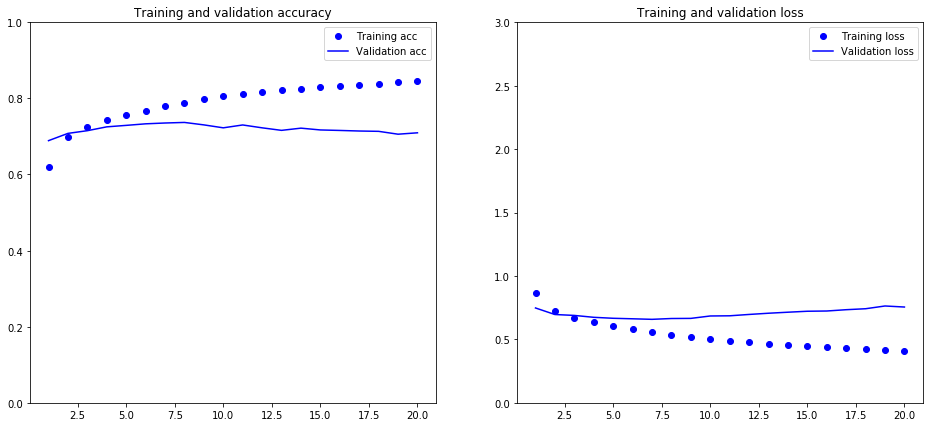

In [41]:
model_name = "model4.hdf5"
m4.save(model_name)
plot_history(h4)

In [42]:
K.clear_session()

m5 = Sequential()
m5.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m5.add(LSTM(16, dropout = 0.2, recurrent_dropout = 0.2))
m5.add(Dropout(0.3))
m5.add(Dense(3, activation = 'softmax'))
m5.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 1,007,539
Trainable params: 1,007,539
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Start timing
start = time.time()

e=15
# Training
print('Training .....')
h5 = m5.fit(train_data_seq, train_one_hot_label, validation_data=(val_data_seq, val_one_hot_label), epochs=e, batch_size=64, verbose=1)
    
stop = time.time()
etime = stop - start

print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, e, etime/e))

Training .....
Train on 18629 samples, validate on 4658 samples
Epoch 1/15
18629/18629 [==============================] - 227s 12ms/step - loss: 0.8556 - acc: 0.6344 - val_loss: 0.7479 - val_acc: 0.6808
Epoch 2/15
18629/18629 [==============================] - 226s 12ms/step - loss: 0.7159 - acc: 0.7023 - val_loss: 0.6910 - val_acc: 0.7145
Epoch 3/15
18629/18629 [==============================] - 227s 12ms/step - loss: 0.6587 - acc: 0.7320 - val_loss: 0.6699 - val_acc: 0.7246
Epoch 4/15
18629/18629 [==============================] - 229s 12ms/step - loss: 0.6179 - acc: 0.7478 - val_loss: 0.6725 - val_acc: 0.7297
Epoch 5/15
18629/18629 [==============================] - 226s 12ms/step - loss: 0.5857 - acc: 0.7666 - val_loss: 0.6648 - val_acc: 0.7304
Epoch 6/15
18629/18629 [==============================] - 226s 12ms/step - loss: 0.5626 - acc: 0.7738 - val_loss: 0.6641 - val_acc: 0.7329
Epoch 7/15
18629/18629 [==============================] - 227s 12ms/step - loss: 0.5424 - acc: 0.7849 

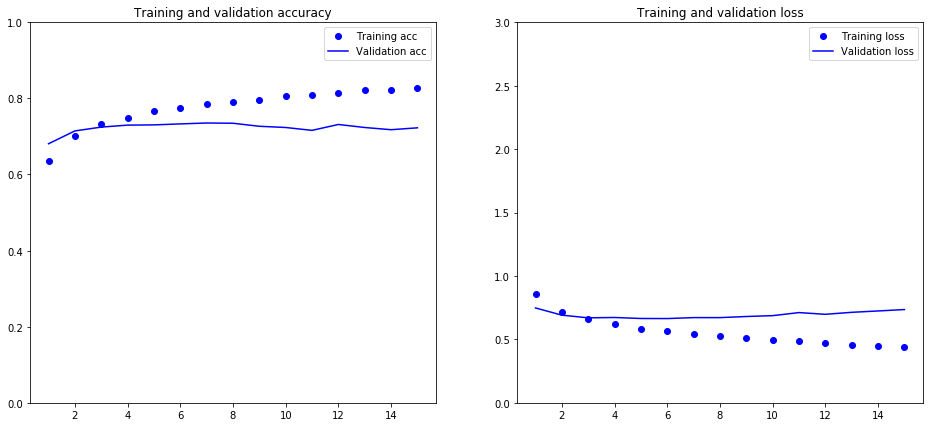

In [44]:
model_name = "model5.hdf5"
m5.save(model_name)
plot_history(h5)

In [45]:
K.clear_session()

m6 = Sequential()
m6.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m6.add(Conv1D(32, 7, activation='relu'))
m6.add(MaxPooling1D(5))
m6.add(Conv1D(32, 7, activation='relu'))
m6.add(GRU(8, dropout = 0.5, recurrent_dropout = 0.3))
m6.add(Dropout(0.5))
m6.add(Dense(3, activation = 'softmax'))
m6.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
m6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 984       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total para

In [46]:
# Start timing
start = time.time()

e=15
# Training
print('Training .....')
h6 = m6.fit(train_data_seq, train_one_hot_label, validation_data=(val_data_seq, val_one_hot_label), epochs=e, batch_size=64, verbose=1)
    
stop = time.time()
etime = stop - start

print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, e, etime/e))

Training .....
Train on 18629 samples, validate on 4658 samples
Epoch 1/15
18629/18629 [==============================] - 39s 2ms/step - loss: 0.5674 - acc: 0.7095 - val_loss: 0.5015 - val_acc: 0.7669
Epoch 2/15
18629/18629 [==============================] - 37s 2ms/step - loss: 0.4961 - acc: 0.7647 - val_loss: 0.4766 - val_acc: 0.7817
Epoch 3/15
18629/18629 [==============================] - 37s 2ms/step - loss: 0.4450 - acc: 0.7970 - val_loss: 0.4780 - val_acc: 0.7847
Epoch 4/15
18629/18629 [==============================] - 38s 2ms/step - loss: 0.3994 - acc: 0.8220 - val_loss: 0.5052 - val_acc: 0.7830
Epoch 5/15
18629/18629 [==============================] - 38s 2ms/step - loss: 0.3591 - acc: 0.8407 - val_loss: 0.5298 - val_acc: 0.7797
Epoch 6/15
18629/18629 [==============================] - 38s 2ms/step - loss: 0.3268 - acc: 0.8568 - val_loss: 0.5780 - val_acc: 0.7816
Epoch 7/15
18629/18629 [==============================] - 37s 2ms/step - loss: 0.3005 - acc: 0.8686 - val_loss: 0.

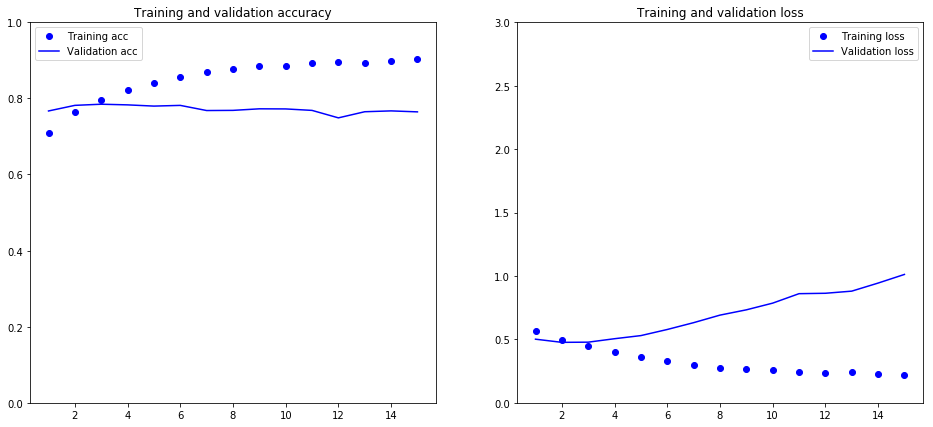

In [47]:
model_name = "model6.hdf5"
m6.save(model_name)
plot_history(h6)

In [37]:

m7 = Sequential()
m7.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m7.add(LSTM(8, dropout = 0.5, recurrent_dropout = 0.2))
m7.add(Dropout(0.5))
m7.add(Dense(3, activation = 'sigmoid'))
m7.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
m7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 27        
Total params: 1,003,515
Trainable params: 1,003,515
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Start timing
start = time.time()

e=20
# Training
print('Training .....')
h7 = m7.fit(train_data_seq, train_one_hot_label, validation_data=(val_data_seq, val_one_hot_label), epochs=e, batch_size=256, verbose=2)
    
stop = time.time()
etime = stop - start

print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, e, etime/e))

Training .....
Train on 18629 samples, validate on 4658 samples
Epoch 1/20
 - 59s - loss: 0.6337 - acc: 0.6849 - val_loss: 0.5652 - val_acc: 0.7236
Epoch 2/20
 - 59s - loss: 0.5614 - acc: 0.7243 - val_loss: 0.5184 - val_acc: 0.7570
Epoch 3/20
 - 61s - loss: 0.5137 - acc: 0.7595 - val_loss: 0.4806 - val_acc: 0.7865
Epoch 4/20
 - 61s - loss: 0.4749 - acc: 0.7841 - val_loss: 0.4604 - val_acc: 0.7958
Epoch 5/20
 - 62s - loss: 0.4460 - acc: 0.8025 - val_loss: 0.4499 - val_acc: 0.8008
Epoch 6/20
 - 62s - loss: 0.4205 - acc: 0.8175 - val_loss: 0.4485 - val_acc: 0.8013
Epoch 7/20
 - 61s - loss: 0.4031 - acc: 0.8289 - val_loss: 0.4452 - val_acc: 0.8033
Epoch 8/20
 - 62s - loss: 0.3848 - acc: 0.8389 - val_loss: 0.4422 - val_acc: 0.8025
Epoch 9/20
 - 69s - loss: 0.3689 - acc: 0.8453 - val_loss: 0.4471 - val_acc: 0.8071
Epoch 10/20
 - 63s - loss: 0.3556 - acc: 0.8525 - val_loss: 0.4496 - val_acc: 0.8055
Epoch 11/20
 - 62s - loss: 0.3450 - acc: 0.8575 - val_loss: 0.4546 - val_acc: 0.8085
Epoch 12/2

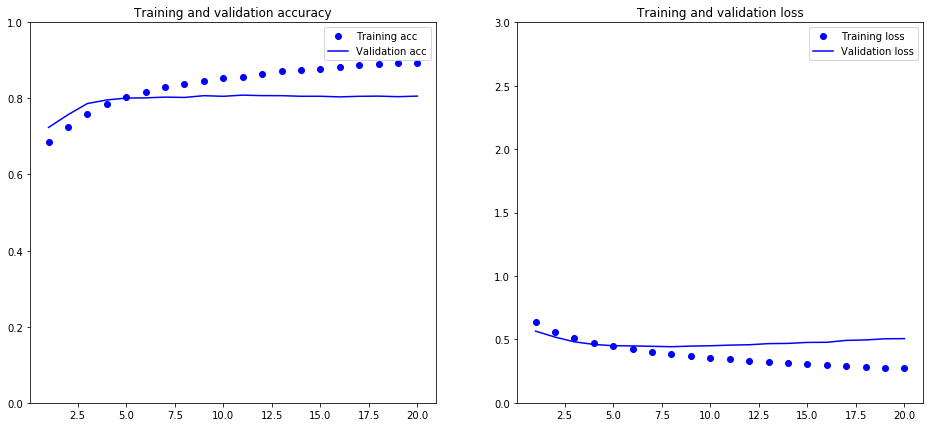

In [39]:
# model_name = "model7.1.h5"
# m7.save(model_name)
plot_history(h7)

In [54]:
from keras.layers import Input, Dense, concatenate, Activation, CuDNNLSTM
from keras.models import Model
from keras import backend as K
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.models import model_from_json
from keras.models import load_model

K.clear_session()

text_input = Input(shape=(500,), dtype='int32')
text_encoder = Embedding(100000, 300, input_length=500,  trainable=True)(text_input)
lstm1 = Bidirectional(CuDNNLSTM(300))(text_encoder)
merged = Dense(32, activation='relu')(lstm1)
merged = Dense(32, activation='relu')(merged)
# merged = Dropout(0.5)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)
model8 = Model(inputs=[text_input], outputs=[output])
model8.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 300)          30000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               1444800   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                19232     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total para

In [55]:
import time
# Start timing
start = time.time()

e=10
# Training
print('Training .....')
h8 = model8.fit(train_data_seq, train_one_hot_label, validation_data=(val_data_seq, val_one_hot_label), epochs=e, batch_size=256, verbose=2)
    
stop = time.time()
etime = stop - start

print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, e, etime/e))

Training .....
Train on 18629 samples, validate on 4658 samples
Epoch 1/10
 - 44s - loss: 0.8377 - acc: 0.6427 - val_loss: 0.7190 - val_acc: 0.6889
Epoch 2/10
 - 43s - loss: 0.5934 - acc: 0.7547 - val_loss: 0.6829 - val_acc: 0.7123
Epoch 3/10
 - 43s - loss: 0.4707 - acc: 0.8110 - val_loss: 0.6972 - val_acc: 0.7147
Epoch 4/10
 - 42s - loss: 0.3964 - acc: 0.8443 - val_loss: 0.7900 - val_acc: 0.7080
Epoch 5/10
 - 42s - loss: 0.3377 - acc: 0.8663 - val_loss: 0.8445 - val_acc: 0.7057
Epoch 6/10
 - 42s - loss: 0.2878 - acc: 0.8882 - val_loss: 0.9033 - val_acc: 0.6997
Epoch 7/10
 - 42s - loss: 0.2531 - acc: 0.9007 - val_loss: 0.9890 - val_acc: 0.6900
Epoch 8/10
 - 42s - loss: 0.2237 - acc: 0.9130 - val_loss: 1.0650 - val_acc: 0.6894
Epoch 9/10
 - 42s - loss: 0.2053 - acc: 0.9200 - val_loss: 1.2062 - val_acc: 0.6863
Epoch 10/10
 - 42s - loss: 0.1929 - acc: 0.9243 - val_loss: 1.1674 - val_acc: 0.6814
Done. Elapsed time 427 seconds for 10 epochs, average 42.7 seconds/epoch.


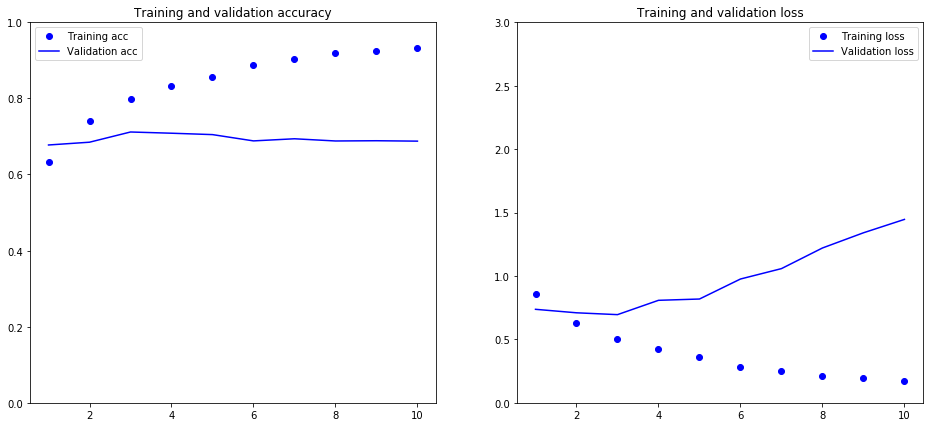

In [43]:
# model_name = "model8.hdf5"
# model8.save(model_name)
plot_history(h8)

### Preprocess the test data set

In [40]:
sequences_test = tokenizer.texts_to_sequences(test['text'])
x_test_seq = pad_sequences(sequences_test, maxlen=max_len)

In [41]:
len(x_test_seq)

4110

## Evaluation and select the best model

In [39]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

y_pred = model8.predict(x_test_seq)
Y_pred = np.argmax(y_pred, axis=1)

results1 = confusion_matrix(test['label'], Y_pred)
print ('Confusion Matrix :')
print (results1) 
print ('Accuracy Score :') 
print (accuracy_score(test['label'], Y_pred))
print ('Report : ')
print (classification_report(test['label'], Y_pred) )

Confusion Matrix :
[[ 268   91  375]
 [  42  654  327]
 [ 234  275 1844]]
Accuracy Score :
0.672992700729927
Report : 
              precision    recall  f1-score   support

           0       0.49      0.37      0.42       734
           1       0.64      0.64      0.64      1023
           2       0.72      0.78      0.75      2353

   micro avg       0.67      0.67      0.67      4110
   macro avg       0.62      0.60      0.60      4110
weighted avg       0.66      0.67      0.67      4110



In [41]:
from keras.models import load_model
model2 = load_model('model2.hdf5')

In [42]:
y_pred = model2.predict(x_test_seq)
Y_pred = np.argmax(y_pred, axis=1)

results1 = confusion_matrix(test['label'], Y_pred)
print ('Confusion Matrix :')
print (results1) 
print ('Accuracy Score :') 
print (accuracy_score(test['label'], Y_pred))
print ('Report : ')
print (classification_report(test['label'], Y_pred) )

Confusion Matrix :
[[   0  156  578]
 [   0  468  555]
 [   0  476 1877]]
Accuracy Score :
0.5705596107055961
Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       734
           1       0.43      0.46      0.44      1023
           2       0.62      0.80      0.70      2353

   micro avg       0.57      0.57      0.57      4110
   macro avg       0.35      0.42      0.38      4110
weighted avg       0.46      0.57      0.51      4110



C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
model5 = load_model('model5.hdf5')

y_pred = model5.predict(x_test_seq)
Y_pred = np.argmax(y_pred, axis=1)

results5 = confusion_matrix(test['label'], Y_pred)
print ('Confusion Matrix :')
print (results1) 
print ('Accuracy Score :') 
print (accuracy_score(test['label'], Y_pred))
print ('Report : ')
print (classification_report(test['label'], Y_pred) )

Confusion Matrix :
[[   0  156  578]
 [   0  468  555]
 [   0  476 1877]]
Accuracy Score :
0.5240875912408759
Report : 
              precision    recall  f1-score   support

           0       0.25      0.12      0.16       734
           1       0.36      0.23      0.28      1023
           2       0.59      0.78      0.67      2353

   micro avg       0.52      0.52      0.52      4110
   macro avg       0.40      0.38      0.37      4110
weighted avg       0.47      0.52      0.48      4110



<b>The best model is model7 with accuracy 0.7<b>

In [42]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
# model7 = load_model('model7.hdf5')

y_pred = m7.predict(x_test_seq)
Y_pred = np.argmax(y_pred, axis=1)

results7 = confusion_matrix(test['label'], Y_pred)
print ('Confusion Matrix :')
print (results7) 
print ('Accuracy Score :') 
print (accuracy_score(test['label'], Y_pred))
print ('Report : ')
print (classification_report(test['label'], Y_pred) )

Confusion Matrix :
[[ 272   68  388]
 [  62  730  265]
 [ 206  227 1892]]
Accuracy Score :
0.7041362530413625
Report : 
              precision    recall  f1-score   support

           0       0.50      0.37      0.43       728
           1       0.71      0.69      0.70      1057
           2       0.74      0.81      0.78      2325

   micro avg       0.70      0.70      0.70      4110
   macro avg       0.65      0.63      0.64      4110
weighted avg       0.69      0.70      0.70      4110



In [44]:
m7=load_model('best_sentiment_model.h5')

In [88]:
y_pred

array([[0.07666103, 0.8850437 , 0.0382953 ],
       [0.7292414 , 0.07101586, 0.19974267],
       [0.03192911, 0.90783775, 0.06023303],
       ...,
       [0.01741187, 0.0050961 , 0.97749203],
       [0.37123013, 0.42521226, 0.20355763],
       [0.00308751, 0.9838193 , 0.01309324]], dtype=float32)

In [53]:
# saving the tokenizer
with open('sentiment_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('sentiment_tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [43]:
results7

array([[ 125,   81,  475],
       [  97,  240,  677],
       [ 283,  393, 1739]], dtype=int64)

In [43]:
test_sentence='ผมว่า ลีโอ รสชาด เวลาเย็นๆ ดื่ม แล้วมันจะกลมกล่อมหวาน ไม่ข่ม ดีสุด'

In [44]:
cut_sentence=word_tokenize(test_sentence.lower() ,engine="newmm")

In [45]:
sequences = tokenizer.texts_to_sequences(cut_sentence)
text_seq = pad_sequences(sequences, maxlen=max_len)

In [49]:
y_pred_test = m7.predict(text_seq)
Y_pred_test = np.argmax(y_pred_test, axis=1)

In [50]:
Y_pred_test

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2], dtype=int64)

In [51]:
import statistics 
from statistics import mode 
  
def most_common(List): 
    return(mode(List)) 

In [52]:
most_common(Y_pred_test)

2